# Bayesian Optimization for Hyperparameter Tuning

In [199]:
#!pip install tpot
#!pip install scikit-optimize
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import zipfile
import urllib.request
import io
import warnings
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split, KFold 
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc, roc_auc_score
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_digits
from skopt import BayesSearchCV, plots
from skopt.space import Real, Categorical, Integer

In [200]:
# raw data
url = "https://github.com/zxyao5148/STAT3612_2023_1A_GroupProject/raw/main/raw_data/ehr_preprocessed_seq_by_day_cat_embedding.pkl.zip"
with urllib.request.urlopen(url) as response:
    with zipfile.ZipFile(io.BytesIO(response.read())) as zip_file:
        with zip_file.open("ehr_preprocessed_seq_by_day_cat_embedding.pkl", "r") as file:
            EHR = pd.read_pickle(file)
train = pd.read_csv("https://github.com/zxyao5148/STAT3612_2023_1A_GroupProject/raw/main/raw_data/train.csv")
valid = pd.read_csv("https://github.com/zxyao5148/STAT3612_2023_1A_GroupProject/raw/main/raw_data/valid.csv")
test = pd.read_csv("https://github.com/zxyao5148/STAT3612_2023_1A_GroupProject/raw/main/raw_data/test.csv")
print(train.shape)
print(test.shape)
print(valid.shape)
print(len(EHR['feature_cols']))

(55941, 13)
(17933, 12)
(13598, 13)
171


In [201]:
# combined data
# load processed data
train_median = pd.read_csv('../data_processing/train/train_valid_mean_mode.csv')
train_latest = pd.read_csv('../data_processing/train/train_valid_latest.csv')
train_dispers = pd.read_csv('../data_processing/train/train_valid_entropy_std.csv')
train_min = pd.read_csv('../data_processing/train/train_valid_min.csv')
train_max = pd.read_csv('../data_processing/train/train_valid_max.csv')
train_q1 = pd.read_csv('../data_processing/train/train_valid_q1.csv')
train_q3 = pd.read_csv('../data_processing/train/train_valid_q3.csv')
train_kurtosis = pd.read_csv('../data_processing/train/train_valid_kurtosis.csv')
train_skewness = pd.read_csv('../data_processing/train/train_valid_skewness.csv')
train_range = pd.read_csv('../data_processing/train/train_valid_range.csv')
train_iqr = pd.read_csv('../data_processing/train/train_valid_iqr.csv')
train_latest = train_latest.drop(train_latest.columns[0:13], axis=1)
train_dispers = train_dispers.drop(train_dispers.columns[0:13], axis=1)
train_min = train_min.drop(train_min.columns[0:13], axis=1)
train_max = train_max.drop(train_max.columns[0:13], axis=1)
train_q1 = train_q1.drop(train_q1.columns[0:13], axis=1)
train_q3 = train_q3.drop(train_q3.columns[0:13], axis=1)
train_kurtois = train_kurtosis.drop(train_kurtosis.columns[0:13], axis=1)
train_skewness = train_skewness.drop(train_skewness.columns[0:13], axis=1)
train_range = train_range.drop(train_range.columns[0:13], axis=1)
train_iqr = train_iqr.drop(train_iqr.columns[0:13], axis=1)

# merge train_median and train_latest
train = pd.concat([train_median, train_latest, train_dispers, train_min, train_max], axis=1)

# load processed data
test_median = pd.read_csv('../data_processing/test/test_mean_mode.csv')
test_latest = pd.read_csv('../data_processing/test/test_latest.csv')
test_dispers = pd.read_csv('../data_processing/test/test_entropy_std.csv')
test_min = pd.read_csv('../data_processing/test/test_min.csv')
test_max = pd.read_csv('../data_processing/test/test_max.csv')
test_q1 = pd.read_csv('../data_processing/test/test_q1.csv')
test_q3 = pd.read_csv('../data_processing/test/test_q3.csv')
test_kurtosis = pd.read_csv('../data_processing/test/test_kurtosis.csv')
test_skewness = pd.read_csv('../data_processing/test/test_skewness.csv')
test_range = pd.read_csv('../data_processing/test/test_range.csv')
test_iqr = pd.read_csv('../data_processing/test/test_iqr.csv')
test_latest = test_latest.drop(test_latest.columns[0:12], axis=1)
test_dispers = test_dispers.drop(test_dispers.columns[0:12], axis=1)
test_min = test_min.drop(test_min.columns[0:12], axis=1)
test_max = test_max.drop(test_max.columns[0:12], axis=1)
test_q1 = test_q1.drop(test_q1.columns[0:12], axis=1)
test_q3 = test_q3.drop(test_q3.columns[0:12], axis=1)
test_kurtosis = test_kurtosis.drop(test_kurtosis.columns[0:12], axis=1)
test_skewness = test_skewness.drop(test_skewness.columns[0:12], axis=1)
test_range = test_range.drop(test_range.columns[0:12], axis=1)
test_iqr = test_iqr.drop(test_iqr.columns[0:12], axis=1)

# merge train_median and train_latest
test = pd.concat([test_median, test_latest, test_dispers, test_min, test_max], axis=1)

In [178]:
# separate response and features
X_train = train.drop(train.columns[0:13], axis=1)
y_train = train["readmitted_within_30days"]
X_test = test.drop(test.columns[0:12], axis=1)

In [172]:
# column categories
cat_cols = [EHR['feature_cols'][i] for i in EHR['cat_idxs']]
icd_cols = EHR['icd_cols']
cat_cols.extend(icd_cols)
num_cols = list(set(EHR['feature_cols']) - set(cat_cols)) 
print(cat_cols)
print(num_cols)

['gender', 'ethnicity', 'Creatinine Blood', 'Sodium Blood', 'pO2 Blood', 'Basophils Other Body Fluid', 'Basophils Pleural', 'Lactate Blood', 'Anion Gap Blood', 'Eosinophils Joint Fluid', 'Hemoglobin Blood', 'Chloride Blood', 'Eosinophils Ascites', 'pH Urine', 'Calcium, Total Blood', 'Lymphocytes Ascites', 'Eosinophils Other Body Fluid', 'Eosinophils Blood', 'Lymphocytes Blood', 'Basophils Joint Fluid', 'Hematocrit Blood', 'Potassium Blood', 'H Blood', 'Monocytes Blood', 'Eosinophils Pleural', 'Troponin T Blood', 'Neutrophils Blood', 'Bicarbonate Blood', 'Basophils Blood', 'Glucose Blood', 'Basophils Ascites', 'pH Blood', 'Platelet Count Blood', 'Lymphocytes Other Body Fluid', 'Monocytes Ascites', 'Lymphocytes Joint Fluid', 'Lymphocytes Pleural', 'pCO2 Blood', 'Y90-Y99', 'G30-G32', 'O85-O92', 'C60-C63', 'F40-F48', 'M80-M85', 'R00-R09', 'J90-J94', 'A00-A09', 'E00-E07', 'F01-F09', 'F30-F39', 'H30-H36', 'D60-D64', 'N00-N08', 'F60-F69', 'I80-I89', 'I95-I99', 'N30-N39', 'K55-K64', 'F50-F59',

In [173]:
num_cols_latest = [f"{col}_latest" for col in num_cols]
num_cols_mean_mode = [f"{col}_mean_mode" for col in num_cols]
num_cols_entropy_std = [f"{col}_entropy_std" for col in num_cols]
num_cols_min = [f"{col}_min" for col in num_cols]
num_cols_max = [f"{col}_max" for col in num_cols]

In [161]:
# adjust imbalance
#import sys
#sys.path.append('../code_base') # relative path to code base
#from adjust_imbl import adjust_imbl
#X_train, y_train = adjust_imbl(X_train, y_train, option='over')

Original dataset shape Counter({0: 9564, 1: 2032})
Resampled dataset shape Counter({1: 9564, 0: 9564})


In [165]:
# feature engineering
#import sys
#sys.path.append('../code_base') # relative path to code base
#from feat_engin import feat_engin
#X_train, X_test = feat_engin(X_train, X_test, num_cols_latest)

In [218]:
# feature selection
#import sys
#sys.path.append('../code_base') # relative path to code base
#from select_feat import select_feat
#X_train = select_feat(X_train, y_train, method='p_value')

In [174]:
# feature standardization
#import sys
#sys.path.append('../code_base') # relative path to code base
#from feat_std import feat_std
#num_cols = num_cols_latest + num_cols_mean_mode + num_cols_entropy_std + num_cols_min + num_cols_max
#X_train, X_test = feat_std(X_train, X_test, num_cols)

In [202]:
lr = LogisticRegression(solver='liblinear', max_iter=100)
params = {
    'penalty': ['l1', 'l2'],
    'C': Real(1e-6, 1e+6, prior='log-uniform')
}
opt = BayesSearchCV(lr, params, n_iter=50, cv=5, scoring='roc_auc', n_jobs=-1)
opt.fit(X_train, y_train)
print("Best params: ", opt.best_params_)
print("Best AUC: %.4f" % opt.best_score_)

array([[<Axes: xlabel='C', ylabel='Partial dependence'>, <Axes: >],
       [<Axes: xlabel='C', ylabel='penalty'>,
        <Axes: xlabel='penalty', ylabel='Partial dependence'>]],
      dtype=object)

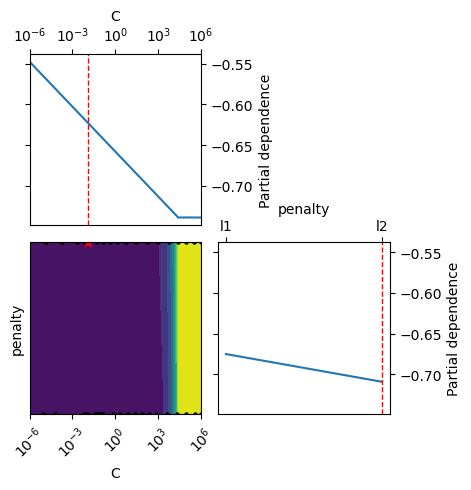

In [30]:
# objective plot
plots.plot_objective(opt.optimizer_results_[0])

array([[<Axes: xlabel='C', ylabel='Number of samples'>, <Axes: >],
       [<Axes: xlabel='C', ylabel='penalty'>,
        <Axes: xlabel='penalty', ylabel='Number of samples'>]],
      dtype=object)

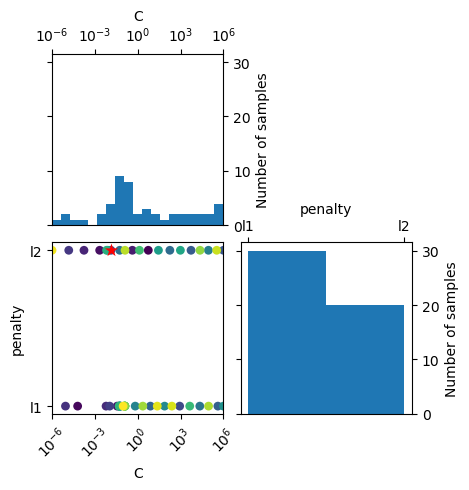

In [31]:
# evaluation plot
plots.plot_evaluations(opt.optimizer_results_[0])

In [144]:
# Linear Discriminant Analysis
lda = LinearDiscriminantAnalysis(solver='lsqr')
params = {
    'shrinkage': Real(0, 1, prior='uniform')
}
opt = BayesSearchCV(lda, params, n_iter=50, cv=5, scoring='roc_auc', n_jobs=-1)
opt.fit(X_train, y_train)
print("Best params: ", opt.best_params_)
print("Best AUC: %.4f" % opt.best_score_)

Best params:  OrderedDict([('shrinkage', 0.1771159102979483)])
Best AUC: 0.8429


<Axes: xlabel='shrinkage', ylabel='Partial dependence'>

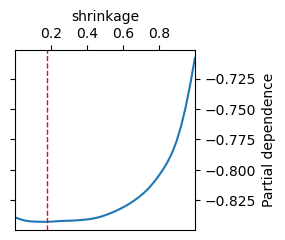

In [145]:
# objective plot
plots.plot_objective(opt.optimizer_results_[0])

<Axes: xlabel='shrinkage', ylabel='Number of samples'>

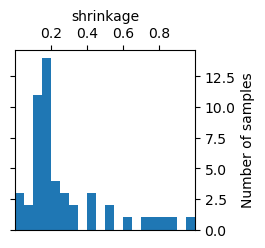

In [146]:
# evaluation plot
plots.plot_evaluations(opt.optimizer_results_[0])

In [38]:
# Quadratic Discriminant Analysis
qda = QuadraticDiscriminantAnalysis()
params = {
    'reg_param': Real(0, 1, prior='uniform')
}
opt = BayesSearchCV(qda, params, n_iter=50, cv=5, scoring='roc_auc', n_jobs=-1)
opt.fit(X_train, y_train)
print("Best params: ", opt.best_params_)
print("Best AUC: %.4f" % opt.best_score_)

/Users/zxyao5148/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/zxyao5148/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/zxyao5148/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/zxyao5148/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/zxyao5148/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/zxyao5148/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear

Best params:  OrderedDict([('reg_param', 0.03839424798540189)])
Best AUC: 0.7077


<Axes: xlabel='reg_param', ylabel='Partial dependence'>

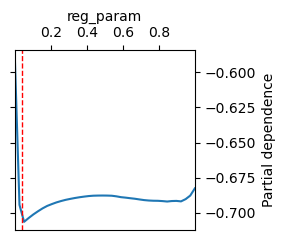

In [39]:
# objective plot
plots.plot_objective(opt.optimizer_results_[0])

<Axes: xlabel='reg_param', ylabel='Number of samples'>

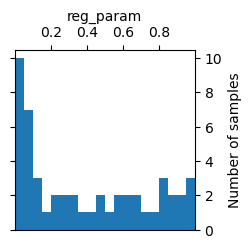

In [40]:
# evaluation plot
plots.plot_evaluations(opt.optimizer_results_[0])

In [41]:
# Naive Bayes
nb = GaussianNB()
params = {
    'var_smoothing': Real(1e-9, 1e-7, prior='log-uniform')
}
opt = BayesSearchCV(nb, params, n_iter=50, cv=5, scoring='roc_auc', n_jobs=-1)
opt.fit(X_train, y_train)
print("Best params: ", opt.best_params_)
print("Best AUC: %.4f" % opt.best_score_)

Best params:  OrderedDict([('var_smoothing', 1.561323861635709e-08)])
Best AUC: 0.5038


<Axes: xlabel='var_smoothing', ylabel='Partial dependence'>

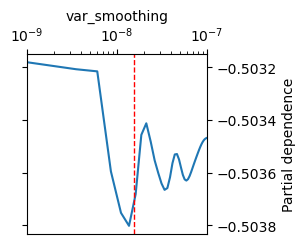

In [42]:
# objective plot
plots.plot_objective(opt.optimizer_results_[0])

<Axes: xlabel='var_smoothing', ylabel='Number of samples'>

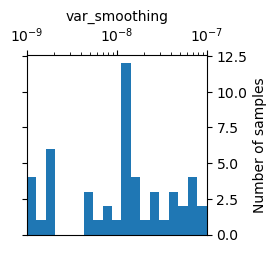

In [43]:
# evaluation plot
plots.plot_evaluations(opt.optimizer_results_[0])

In [64]:
# K-Nearest Neighbors
knn = KNeighborsClassifier()
params = {
    'n_neighbors': Integer(1, 100)
}
opt = BayesSearchCV(knn, params, n_iter=50, cv=5, scoring='roc_auc', n_jobs=-1)
opt.fit(X_train, y_train)
print("Best params: ", opt.best_params_)
print("Best AUC: %.4f" % opt.best_score_)

Best params:  OrderedDict([('n_neighbors', 72)])
Best AUC: 0.7116


<Axes: xlabel='n_neighbors', ylabel='Partial dependence'>

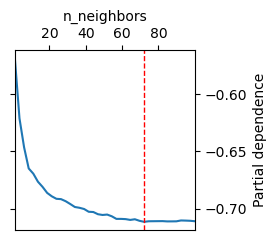

In [65]:
# objective plot
plots.plot_objective(opt.optimizer_results_[0])

<Axes: xlabel='n_neighbors', ylabel='Number of samples'>

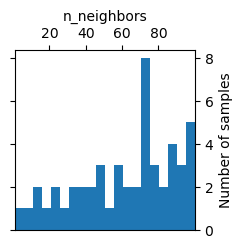

In [66]:
# evaluation plot
plots.plot_evaluations(opt.optimizer_results_[0])

In [ ]:
# Support Vector Machine
svm = SVC(probability=True)
params = {
    'C': Real(1e-6, 1e+6, prior='log-uniform'),
    'gamma': Real(1e-6, 1e+1, prior='log-uniform'),
    'degree': Integer(1, 8)
}
opt = BayesSearchCV(svm, params, n_iter=50, cv=5, scoring='roc_auc', n_jobs=-1)
opt.fit(X_train, y_train)
print("Best params: ", opt.best_params_)
print("Best AUC: %.4f" % opt.best_score_)

In [ ]:
# objective plot
plots.plot_objective(opt.optimizer_results_[0])

In [ ]:
# evaluation plot
plots.plot_evaluations(opt.optimizer_results_[0])

In [133]:
# Decision Tree
dt = DecisionTreeClassifier()
params = {
    'max_depth': Integer(1, 100),
    'min_samples_split': Integer(2, 100),
    'min_samples_leaf': Integer(1, 100)
}
opt = BayesSearchCV(dt, params, n_iter=50, cv=5, scoring='roc_auc', n_jobs=-1)
opt.fit(X_train, y_train)
print("Best params: ", opt.best_params_)
print("Best AUC: %.4f" % opt.best_score_)

Best params:  OrderedDict([('max_depth', 100), ('min_samples_leaf', 14), ('min_samples_split', 99)])
Best AUC: 0.8947


array([[<Axes: xlabel='max_depth', ylabel='Partial dependence'>,
        <Axes: >, <Axes: >],
       [<Axes: ylabel='min_samples_leaf'>,
        <Axes: xlabel='min_samples_leaf', ylabel='Partial dependence'>,
        <Axes: >],
       [<Axes: xlabel='max_depth', ylabel='min_samples_split'>,
        <Axes: xlabel='min_samples_leaf'>,
        <Axes: xlabel='min_samples_split', ylabel='Partial dependence'>]],
      dtype=object)

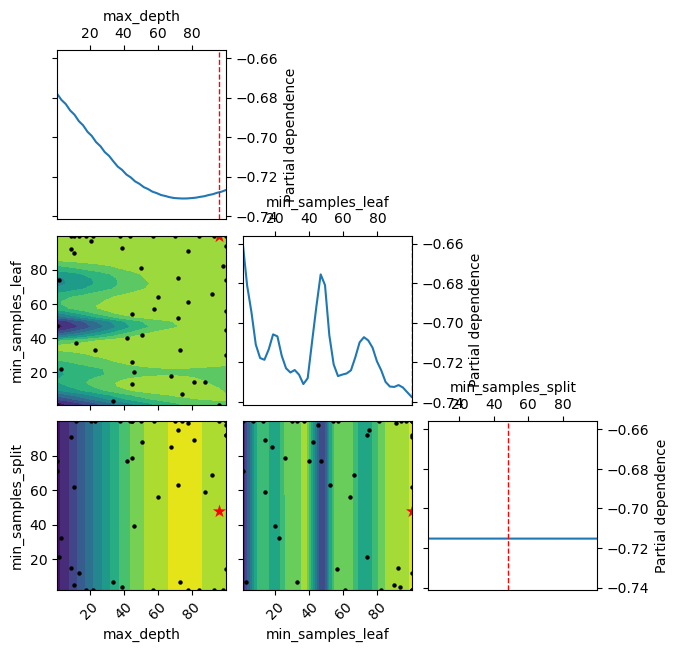

In [47]:
# objective plot
plots.plot_objective(opt.optimizer_results_[0])

array([[<Axes: xlabel='max_depth', ylabel='Number of samples'>, <Axes: >,
        <Axes: >],
       [<Axes: ylabel='min_samples_leaf'>,
        <Axes: xlabel='min_samples_leaf', ylabel='Number of samples'>,
        <Axes: >],
       [<Axes: xlabel='max_depth', ylabel='min_samples_split'>,
        <Axes: xlabel='min_samples_leaf'>,
        <Axes: xlabel='min_samples_split', ylabel='Number of samples'>]],
      dtype=object)

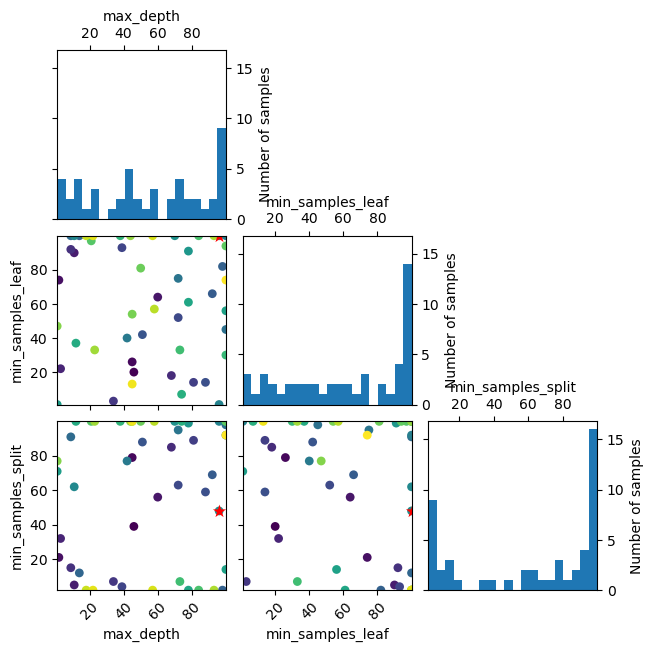

In [48]:
# evaluation plot
plots.plot_evaluations(opt.optimizer_results_[0])

In [114]:
# Bagging
bag = BaggingClassifier()
params = {
    'n_estimators': Integer(10, 100),
    'max_samples': Real(0.1, 1, prior='uniform'),
    'max_features': Real(0.1, 1, prior='uniform')
}
opt = BayesSearchCV(bag, params, n_iter=50, cv=5, scoring='roc_auc', n_jobs=-1)
opt.fit(X_train, y_train)
print("Best params: ", opt.best_params_)
print("Best AUC: %.4f" % opt.best_score_)

197937.43s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
0.01s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


KeyboardInterrupt: 

array([[<Axes: xlabel='max_features', ylabel='Partial dependence'>,
        <Axes: >, <Axes: >],
       [<Axes: ylabel='max_samples'>,
        <Axes: xlabel='max_samples', ylabel='Partial dependence'>,
        <Axes: >],
       [<Axes: xlabel='max_features', ylabel='n_estimators'>,
        <Axes: xlabel='max_samples'>,
        <Axes: xlabel='n_estimators', ylabel='Partial dependence'>]],
      dtype=object)

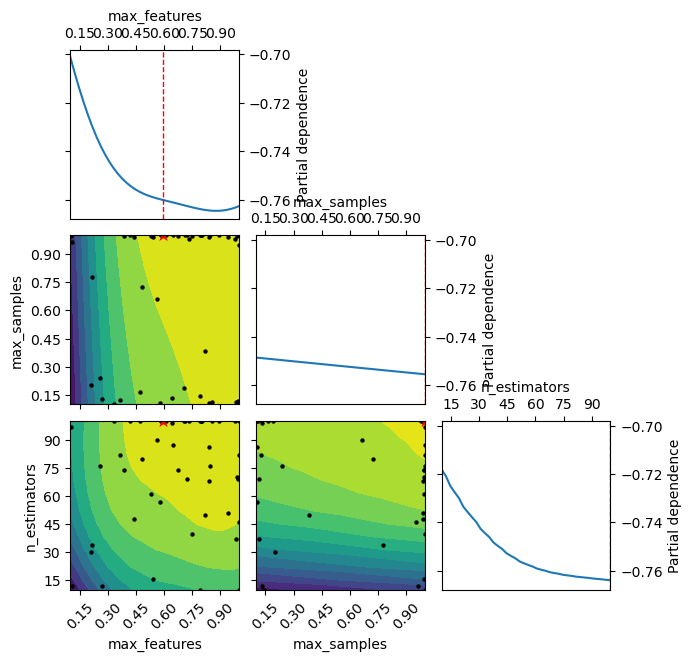

In [50]:
# objective plot
plots.plot_objective(opt.optimizer_results_[0])

array([[<Axes: xlabel='max_features', ylabel='Number of samples'>,
        <Axes: >, <Axes: >],
       [<Axes: ylabel='max_samples'>,
        <Axes: xlabel='max_samples', ylabel='Number of samples'>,
        <Axes: >],
       [<Axes: xlabel='max_features', ylabel='n_estimators'>,
        <Axes: xlabel='max_samples'>,
        <Axes: xlabel='n_estimators', ylabel='Number of samples'>]],
      dtype=object)

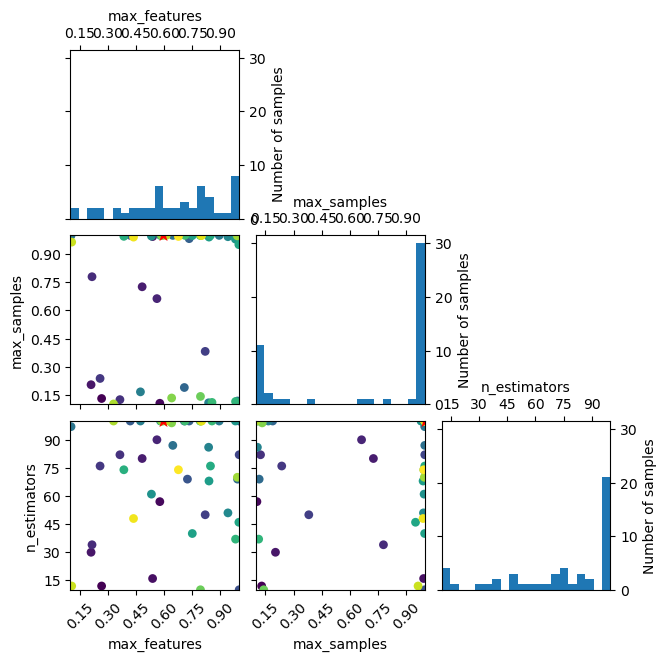

In [51]:
# evaluation plot
plots.plot_evaluations(opt.optimizer_results_[0])

In [243]:
# Random Forest
rf = RandomForestClassifier()
params = {
    'n_estimators': Integer(10, 100),
    'max_depth': Integer(1, 100),
    'min_samples_split': Integer(2, 100),
    'min_samples_leaf': Integer(1, 100)
}
opt = BayesSearchCV(rf, params, n_iter=50, cv=5, scoring='roc_auc', n_jobs=-1)
opt.fit(X_train, y_train)
print("Best params: ", opt.best_params_)
print("Best AUC: %.4f" % opt.best_score_)

253511.28s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
253511.28s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
253511.28s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
253511.32s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
253511.32s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
253511.31s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
253511.31s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
253511.32s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.01s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfroz

Best params:  OrderedDict([('max_depth', 53), ('min_samples_leaf', 10), ('min_samples_split', 2), ('n_estimators', 100)])
Best AUC: 0.7900


array([[<Axes: xlabel='max_depth', ylabel='Partial dependence'>,
        <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='min_samples_leaf'>,
        <Axes: xlabel='min_samples_leaf', ylabel='Partial dependence'>,
        <Axes: >, <Axes: >],
       [<Axes: ylabel='min_samples_split'>, <Axes: >,
        <Axes: xlabel='min_samples_split', ylabel='Partial dependence'>,
        <Axes: >],
       [<Axes: xlabel='max_depth', ylabel='n_estimators'>,
        <Axes: xlabel='min_samples_leaf'>,
        <Axes: xlabel='min_samples_split'>,
        <Axes: xlabel='n_estimators', ylabel='Partial dependence'>]],
      dtype=object)

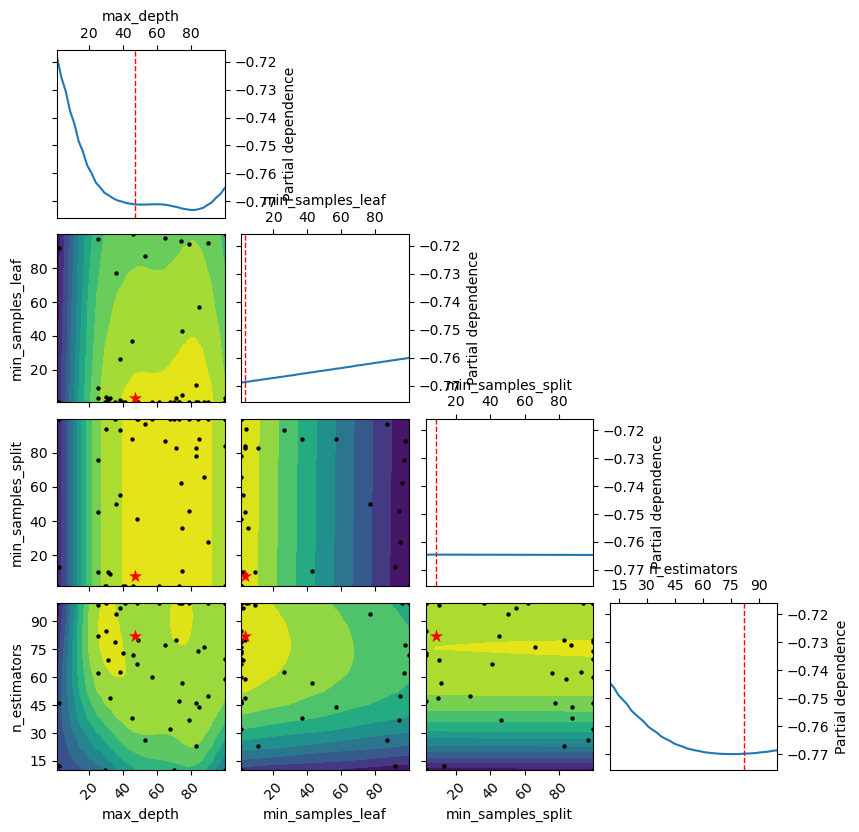

In [53]:
# objective plot
plots.plot_objective(opt.optimizer_results_[0])

array([[<Axes: xlabel='max_depth', ylabel='Number of samples'>, <Axes: >,
        <Axes: >, <Axes: >],
       [<Axes: ylabel='min_samples_leaf'>,
        <Axes: xlabel='min_samples_leaf', ylabel='Number of samples'>,
        <Axes: >, <Axes: >],
       [<Axes: ylabel='min_samples_split'>, <Axes: >,
        <Axes: xlabel='min_samples_split', ylabel='Number of samples'>,
        <Axes: >],
       [<Axes: xlabel='max_depth', ylabel='n_estimators'>,
        <Axes: xlabel='min_samples_leaf'>,
        <Axes: xlabel='min_samples_split'>,
        <Axes: xlabel='n_estimators', ylabel='Number of samples'>]],
      dtype=object)

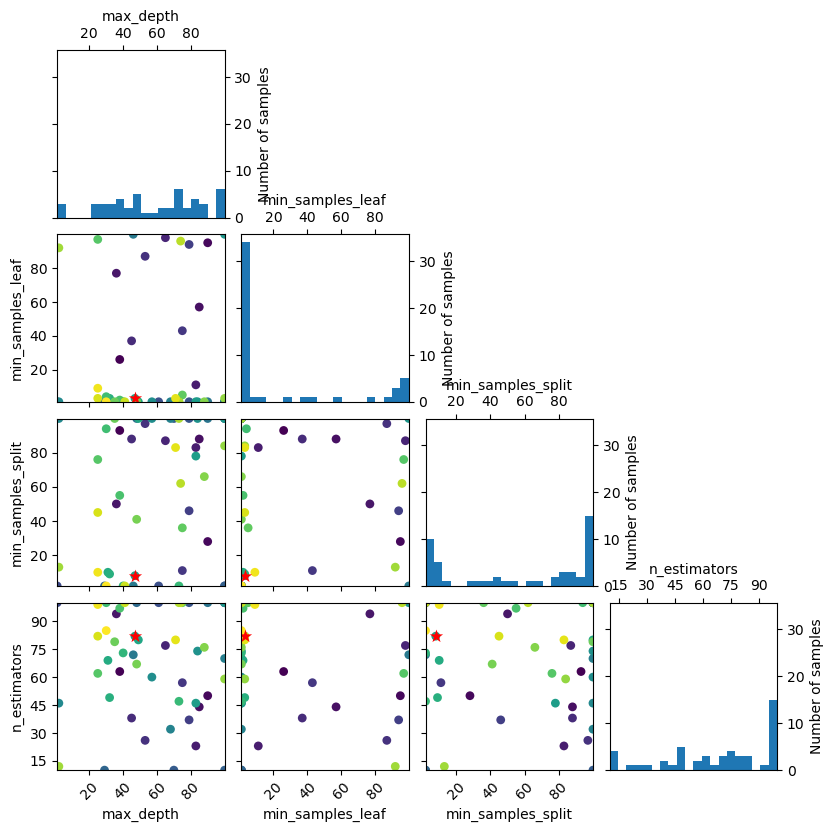

In [54]:
# evaluation plot
plots.plot_evaluations(opt.optimizer_results_[0])

In [244]:
# Gradient Boosting
gb = GradientBoostingClassifier()
params = {
    'n_estimators': Integer(10, 100),
    'learning_rate': Real(1e-6, 1e+1, prior='log-uniform'),
    'max_depth': Integer(1, 100),
    'min_samples_split': Integer(2, 100),
    'min_samples_leaf': Integer(1, 100)
}
opt = BayesSearchCV(gb, params, n_iter=50, cv=5, scoring='roc_auc', n_jobs=-1)
opt.fit(X_train, y_train)
print("Best params: ", opt.best_params_)
print("Best AUC: %.4f" % opt.best_score_)

254287.73s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
254287.72s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
254287.72s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
254287.75s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
254287.75s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
254287.75s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
254287.75s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
254287.75s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
0.01s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debuggi

Best params:  OrderedDict([('learning_rate', 0.03738966639696924), ('max_depth', 26), ('min_samples_leaf', 100), ('min_samples_split', 100), ('n_estimators', 93)])
Best AUC: 0.8027


array([[<Axes: xlabel='learning_rate', ylabel='Partial dependence'>,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='max_depth'>,
        <Axes: xlabel='max_depth', ylabel='Partial dependence'>,
        <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='min_samples_leaf'>, <Axes: >,
        <Axes: xlabel='min_samples_leaf', ylabel='Partial dependence'>,
        <Axes: >, <Axes: >],
       [<Axes: ylabel='min_samples_split'>, <Axes: >, <Axes: >,
        <Axes: xlabel='min_samples_split', ylabel='Partial dependence'>,
        <Axes: >],
       [<Axes: xlabel='learning_rate', ylabel='n_estimators'>,
        <Axes: xlabel='max_depth'>, <Axes: xlabel='min_samples_leaf'>,
        <Axes: xlabel='min_samples_split'>,
        <Axes: xlabel='n_estimators', ylabel='Partial dependence'>]],
      dtype=object)

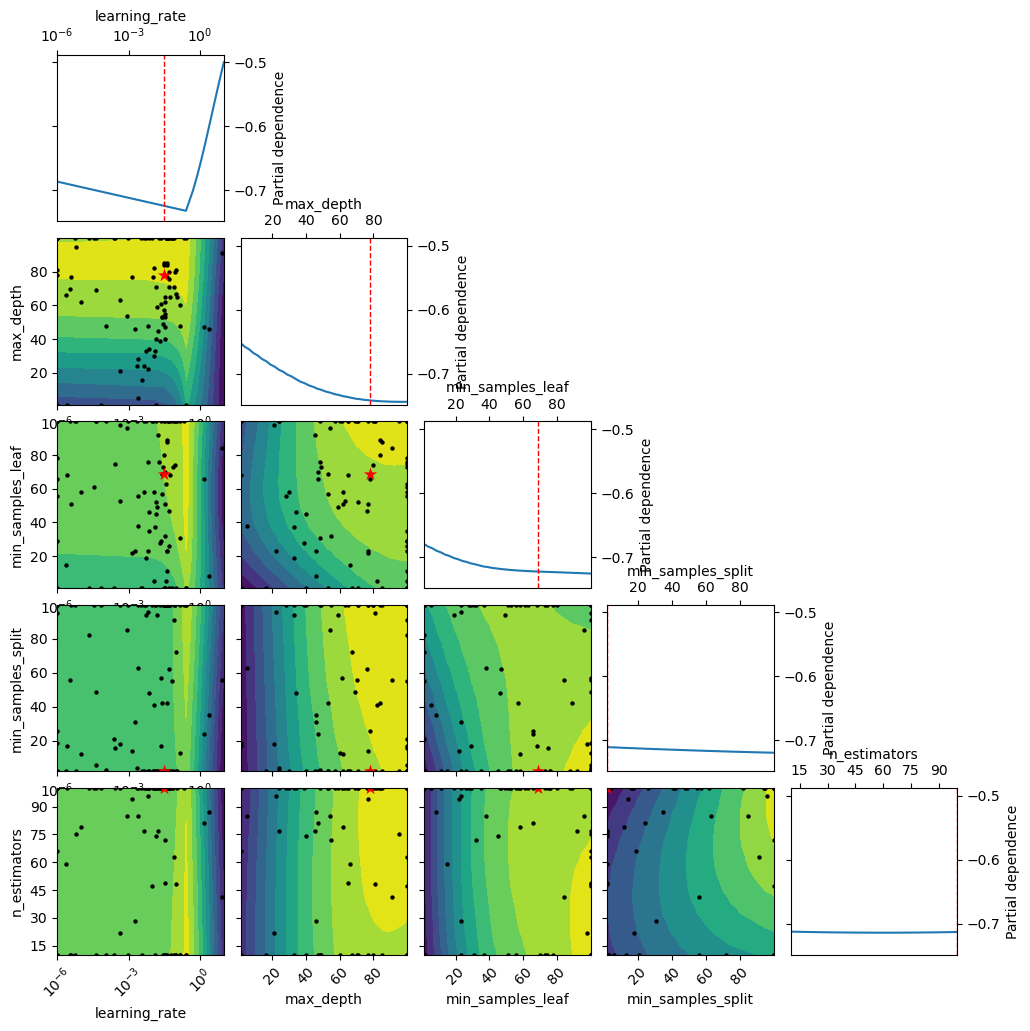

In [101]:
# objective plot
plots.plot_objective(opt.optimizer_results_[0])

array([[<Axes: xlabel='learning_rate', ylabel='Number of samples'>,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='max_depth'>,
        <Axes: xlabel='max_depth', ylabel='Number of samples'>, <Axes: >,
        <Axes: >, <Axes: >],
       [<Axes: ylabel='min_samples_leaf'>, <Axes: >,
        <Axes: xlabel='min_samples_leaf', ylabel='Number of samples'>,
        <Axes: >, <Axes: >],
       [<Axes: ylabel='min_samples_split'>, <Axes: >, <Axes: >,
        <Axes: xlabel='min_samples_split', ylabel='Number of samples'>,
        <Axes: >],
       [<Axes: xlabel='learning_rate', ylabel='n_estimators'>,
        <Axes: xlabel='max_depth'>, <Axes: xlabel='min_samples_leaf'>,
        <Axes: xlabel='min_samples_split'>,
        <Axes: xlabel='n_estimators', ylabel='Number of samples'>]],
      dtype=object)

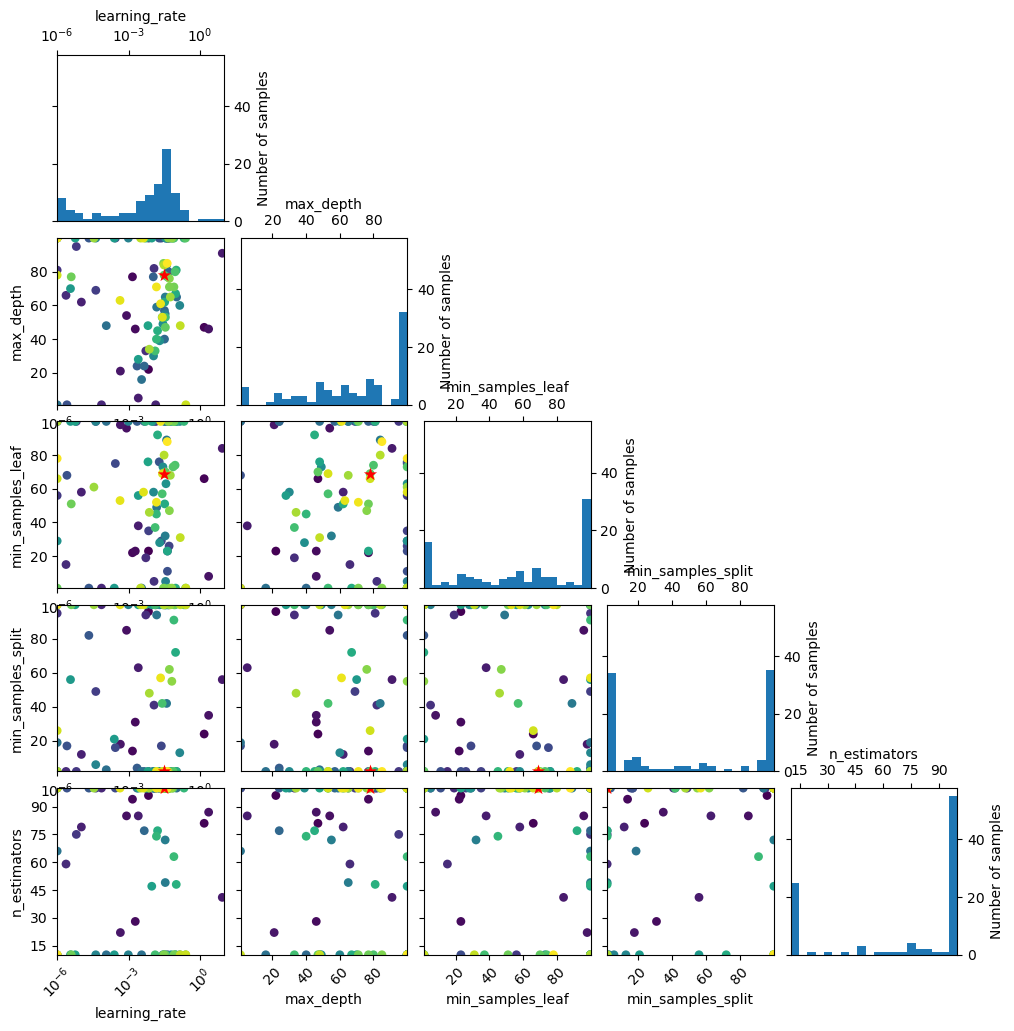

In [102]:
# evaluation plot
plots.plot_evaluations(opt.optimizer_results_[0])

In [58]:
# AdaBoost
ada = AdaBoostClassifier()
params = {
    'n_estimators': Integer(10, 100),
    'learning_rate': Real(1e-6, 1e+1, prior='log-uniform')
}
opt = BayesSearchCV(ada, params, n_iter=50, cv=5, scoring='roc_auc', n_jobs=-1)
opt.fit(X_train, y_train)
print("Best params: ", opt.best_params_)
print("Best AUC: %.4f" % opt.best_score_)

Best params:  OrderedDict([('learning_rate', 0.3745446795636484), ('n_estimators', 92)])
Best AUC: 0.7651


array([[<Axes: xlabel='learning_rate', ylabel='Partial dependence'>,
        <Axes: >],
       [<Axes: xlabel='learning_rate', ylabel='n_estimators'>,
        <Axes: xlabel='n_estimators', ylabel='Partial dependence'>]],
      dtype=object)

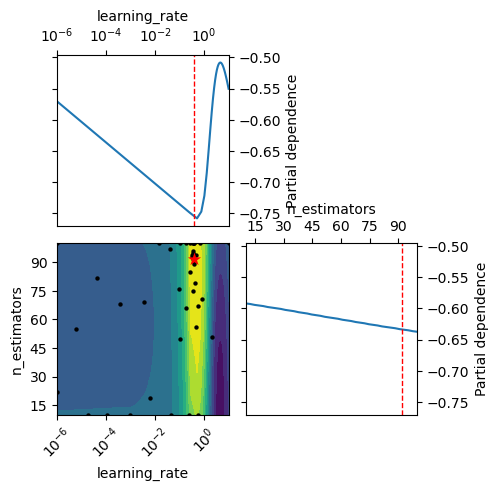

In [59]:
# objective plot
plots.plot_objective(opt.optimizer_results_[0])

array([[<Axes: xlabel='learning_rate', ylabel='Number of samples'>,
        <Axes: >],
       [<Axes: xlabel='learning_rate', ylabel='n_estimators'>,
        <Axes: xlabel='n_estimators', ylabel='Number of samples'>]],
      dtype=object)

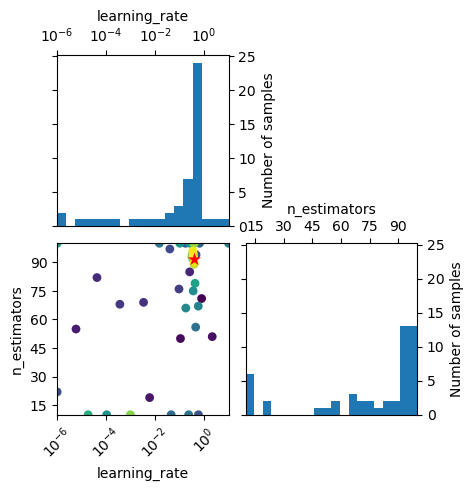

In [60]:
# evaluation plot
plots.plot_evaluations(opt.optimizer_results_[0])

In [195]:
# XGBoost
xgb = XGBClassifier(random_state=42)
params = {
    'n_estimators': Integer(10, 100),
    'learning_rate': Real(1e-6, 1e+1, prior='log-uniform'),
    'max_depth': Integer(1, 100),
    'min_child_weight': Integer(1, 100),
    'subsample': Real(0.1, 1, prior='uniform'),
    'colsample_bytree': Real(0.1, 1, prior='uniform'),
    'scale_pos_weight': Real(1, 10, prior='uniform'),
    #'gamma': Real(0, 10, prior='uniform'),
    #'reg_alpha': Real(0, 1, prior='uniform'),
    #'reg_lambda': Real(0, 1, prior='uniform')
}
opt = BayesSearchCV(xgb, params, n_iter=50, cv=10, scoring='roc_auc', n_jobs=-1)
opt.fit(X_train, y_train)
print("Best params: ", opt.best_params_)
print("Best AUC: %.4f" % opt.best_score_)

Best params:  OrderedDict([('colsample_bytree', 0.5887804132886073), ('learning_rate', 0.041271158658984446), ('max_depth', 93), ('min_child_weight', 47), ('n_estimators', 97), ('scale_pos_weight', 3.7667235334304814), ('subsample', 0.7197278881395018)])
Best AUC: 0.8084


array([[<Axes: xlabel='colsample_bytree', ylabel='Partial dependence'>,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='learning_rate'>,
        <Axes: xlabel='learning_rate', ylabel='Partial dependence'>,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='max_depth'>, <Axes: >,
        <Axes: xlabel='max_depth', ylabel='Partial dependence'>,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='min_child_weight'>, <Axes: >, <Axes: >,
        <Axes: xlabel='min_child_weight', ylabel='Partial dependence'>,
        <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='n_estimators'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: xlabel='n_estimators', ylabel='Partial dependence'>,
        <Axes: >, <Axes: >],
       [<Axes: ylabel='scale_pos_weight'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >,
        <Axes: xlabel='scale_pos_weight', ylabel='Partial dependence'>,
        <Axes: >],
       [<

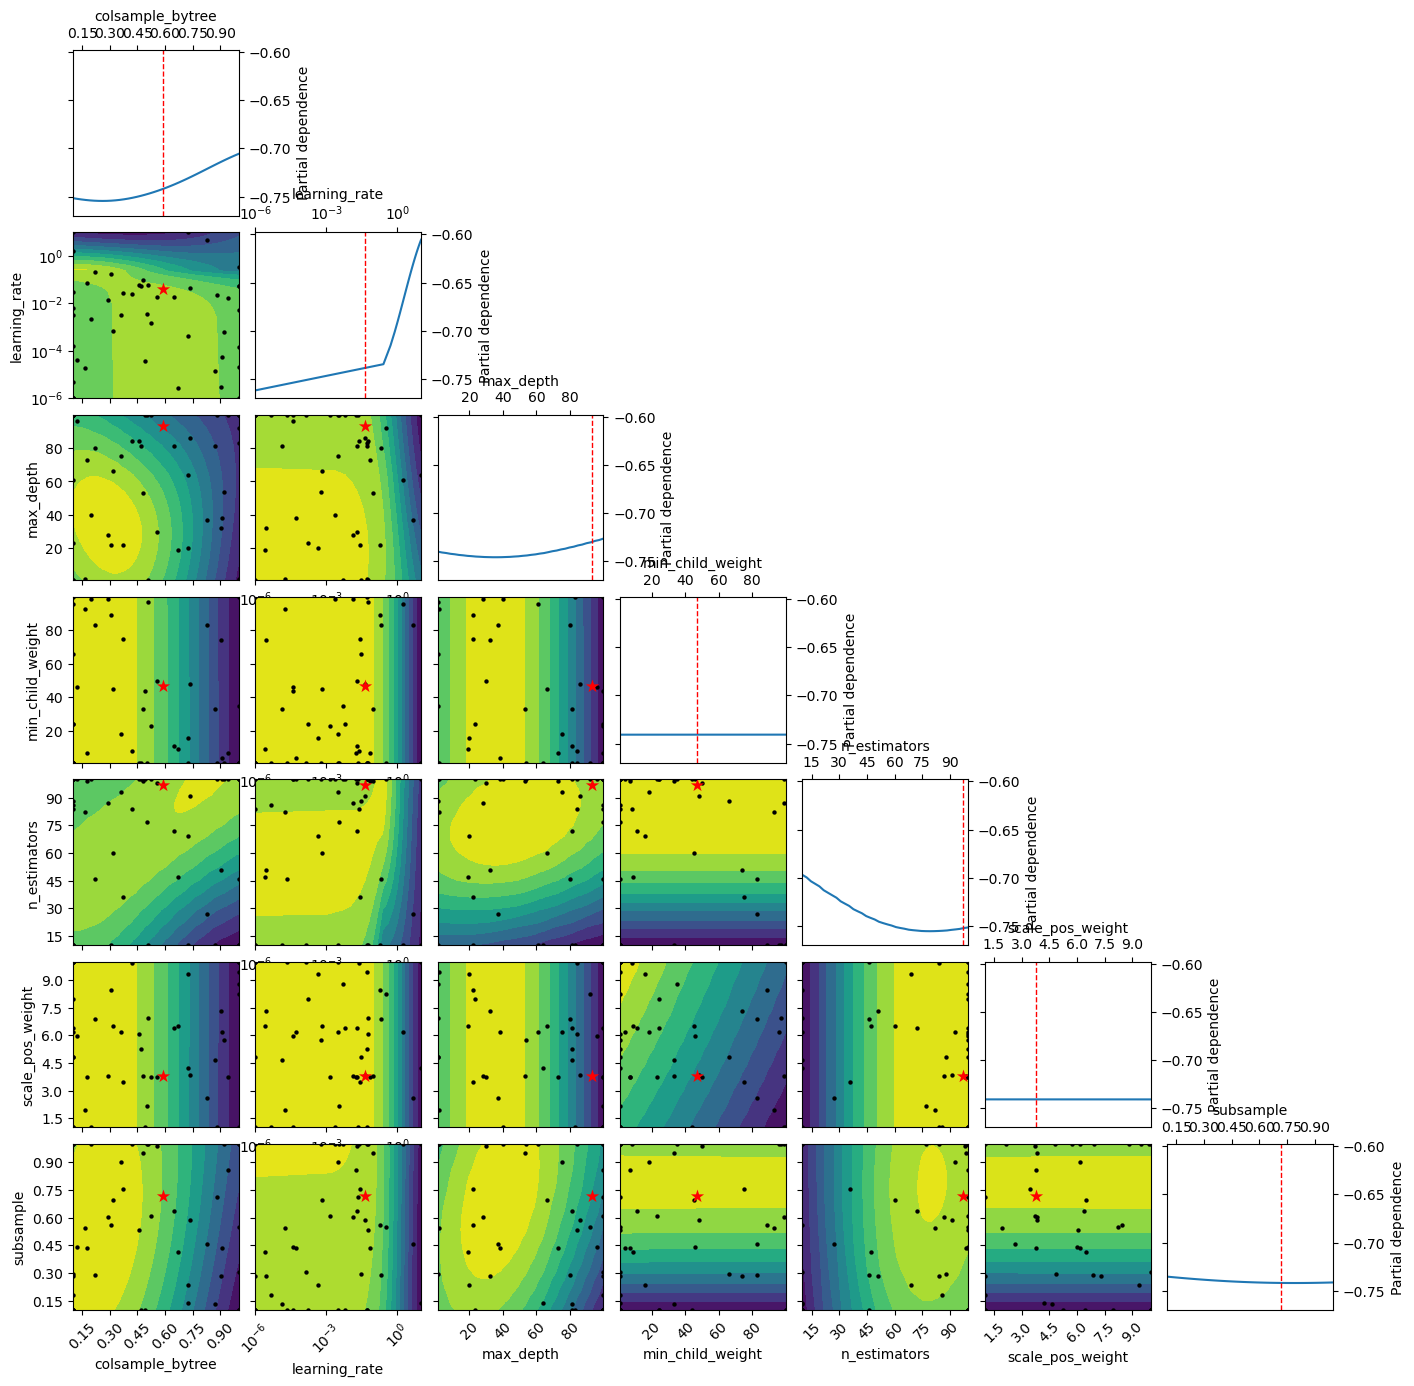

In [196]:
# objective plot
plots.plot_objective(opt.optimizer_results_[0])

array([[<Axes: xlabel='colsample_bytree', ylabel='Number of samples'>,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='learning_rate'>,
        <Axes: xlabel='learning_rate', ylabel='Number of samples'>,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='max_depth'>, <Axes: >,
        <Axes: xlabel='max_depth', ylabel='Number of samples'>, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='min_child_weight'>, <Axes: >, <Axes: >,
        <Axes: xlabel='min_child_weight', ylabel='Number of samples'>,
        <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='n_estimators'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: xlabel='n_estimators', ylabel='Number of samples'>,
        <Axes: >, <Axes: >],
       [<Axes: ylabel='scale_pos_weight'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >,
        <Axes: xlabel='scale_pos_weight', ylabel='Number of samples'>,
        <Axes: >],
       [<Axes: 

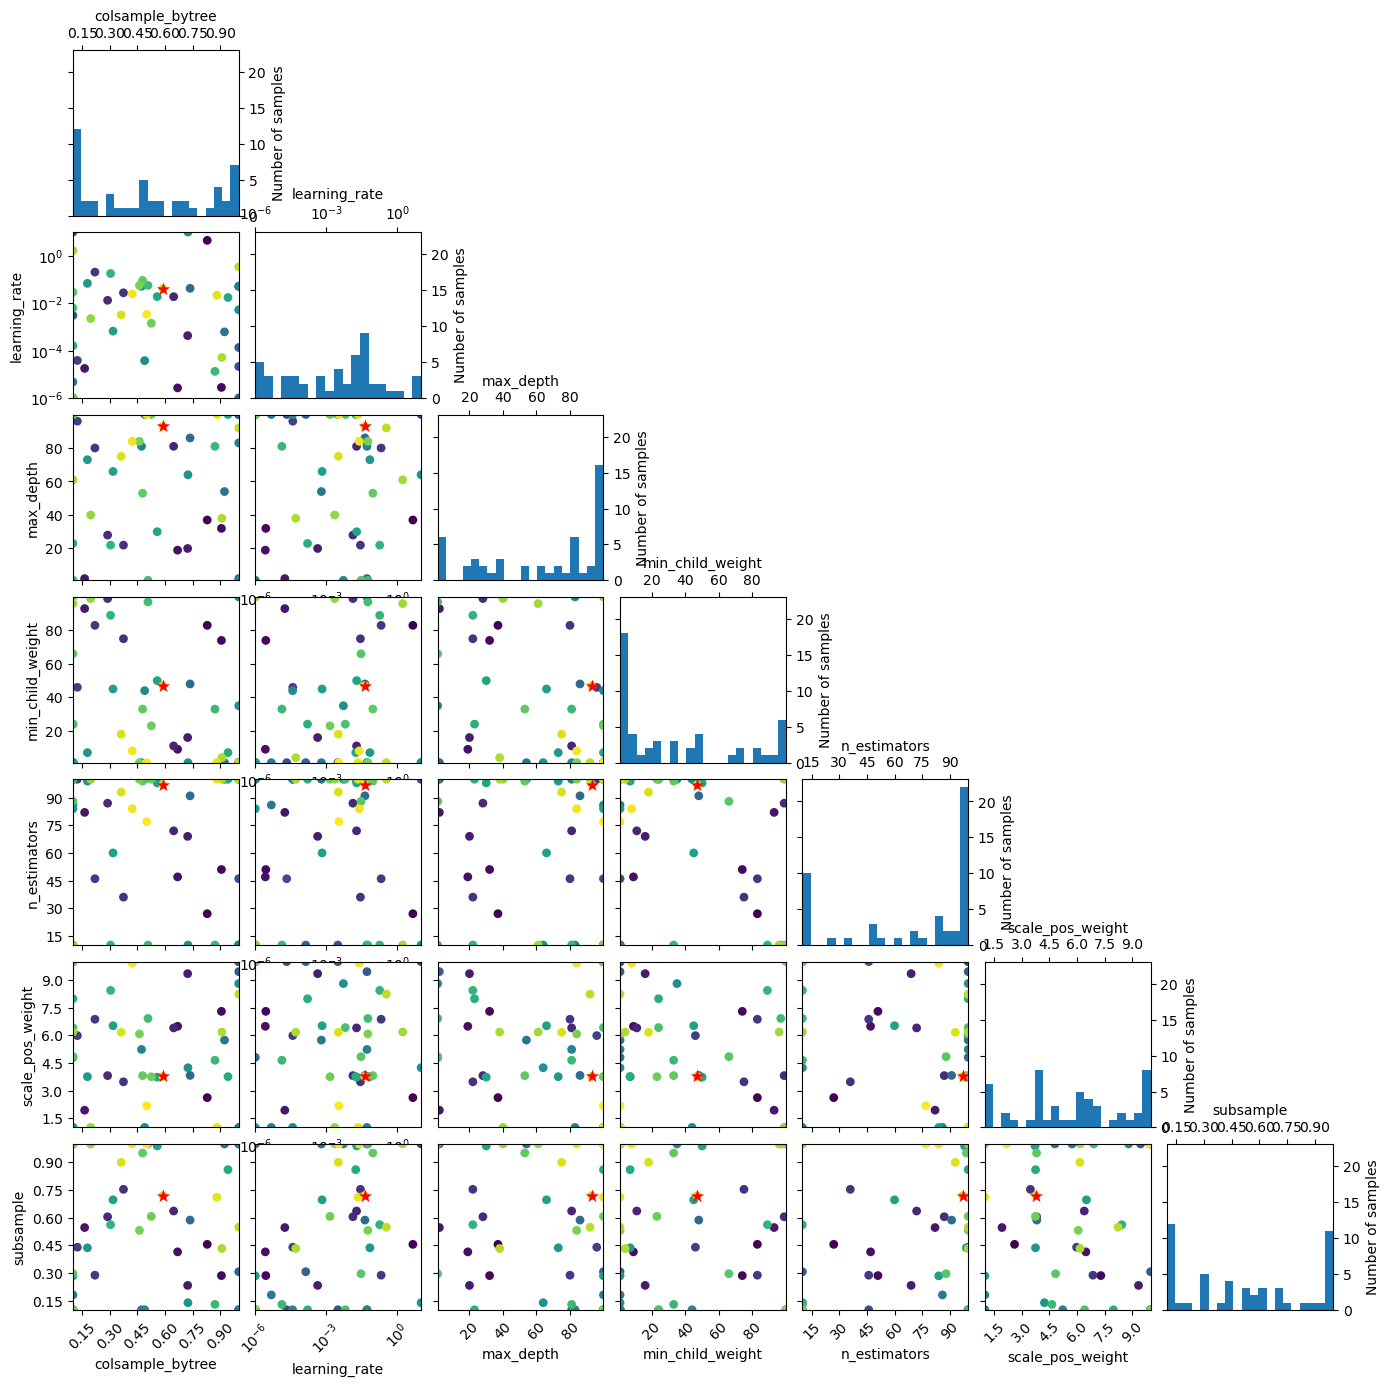

In [197]:
# evaluation plot
plots.plot_evaluations(opt.optimizer_results_[0])

In [198]:
# make predictions
y_test = opt.predict_proba(X_test)
y_test = y_test[:,1]
df = pd.DataFrame({'id': test['id'], 'readmitted_within_30days': y_test})
df.to_csv('../df.csv', index=False)